# Data Challenge 2

## Download data

In [1]:
#! pip install -q lalsuite
#! pip install -q gwpy
#! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

--2022-05-26 05:10:31--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf’

challenge2.gwf      100%[===================>]   3.84M  3.23MB/s    in 1.2s    

2022-05-26 05:10:34 (3.23 MB/s) - ‘challenge2.gwf’ saved [4025842/4025842]



## Sampling rate and duration

In [2]:
duration = len(gwpy_strain)*gwpy_strain.dt
sampling_rate = 1/gwpy_strain.dt
print("duration = {}".format(duration))
print("sampling rate = {}".format(sampling_rate))

duration = 128.0 s
sampling rate = 4096.0 1 / s


## Plotting the data

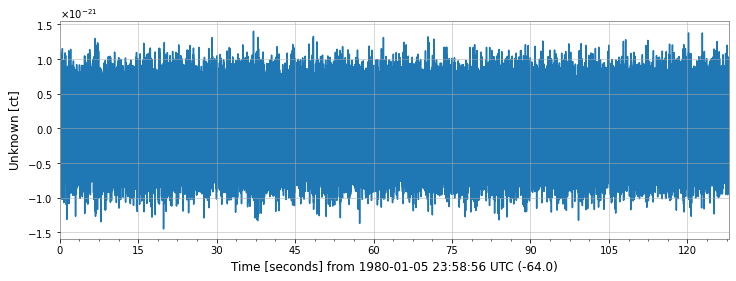

In [3]:
%matplotlib inline
plot = gwpy_strain.plot()

## Q-transform

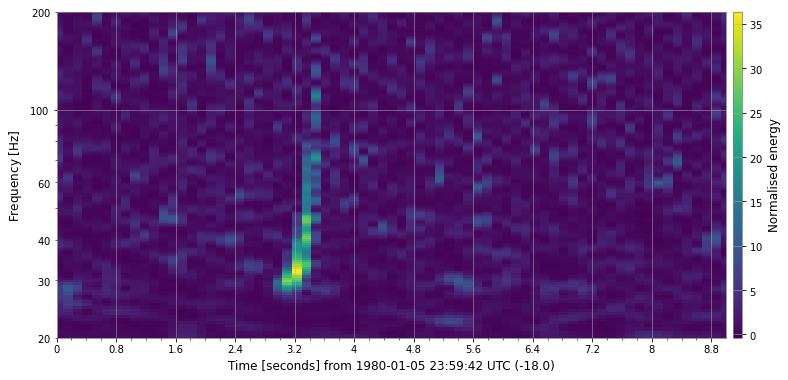

In [4]:
hq = gwpy_strain.q_transform(frange=(20, 200), qrange=(30, 80))
plot_hq = hq.plot()
ax = plot_hq.gca()
ax.set_yscale('log')
ax.set_xlim(46-64, 55-64)
#ax.set_xlim(0, -16)
ax.colorbar(label="Normalised energy")

Merger time: 1980-01-05 23:59:45.6 (3.6-18=-14.4)

# Time domain waveform

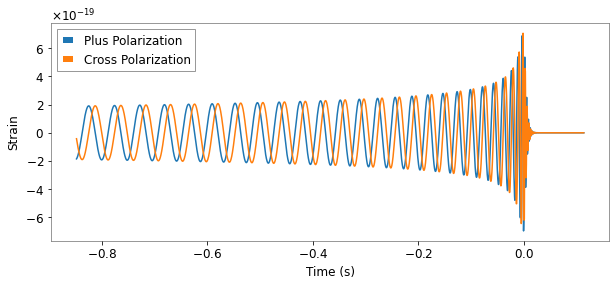

In [21]:
from pycbc.waveform import get_td_waveform
import pylab
%matplotlib inline

sample_delta_t = 1.0/2048

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=sample_delta_t,
                         f_lower=20)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

## Generate the PSD

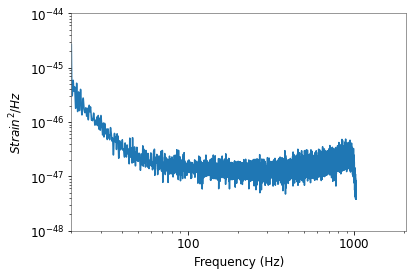

In [22]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(pycbc_strain, 15.0)
strain = resample_to_delta_t(strain, sample_delta_t)
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)
# We use 16 second samples of our time series in Welch method.
p = conditioned.psd(16)
p = interpolate(p, conditioned.delta_f)
p = inverse_spectrum_truncation(p, int(4 * conditioned.sample_rate), low_frequency_cutoff=20.0)
psd = p

pylab.plot(psd.sample_frequencies, psd)
pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-48, 1e-44)
pylab.xlim(20, 2048)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.show()

## Matched filtering

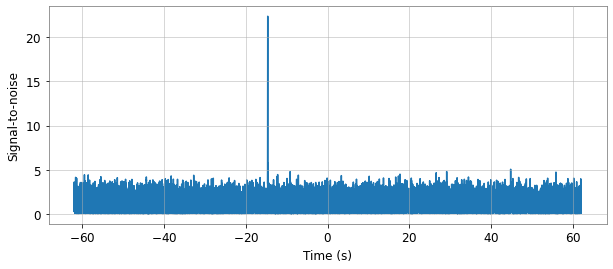

We found a signal at -14.6328125s with SNR 22.366010082131336


In [26]:
from pycbc.filter import matched_filter
import numpy

# Resize the vector to match our data
hp.resize(len(conditioned))
hc.resize(len(conditioned))

template_p = hp.cyclic_time_shift(hp.start_time)
template_c = hc.cyclic_time_shift(hc.start_time)

snr_p = matched_filter(template_p, conditioned,psd=psd, low_frequency_cutoff=20)
snr_c = matched_filter(template_c, conditioned,psd=psd, low_frequency_cutoff=20)
snr = snr_p

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))